In [1]:
import torchvision.transforms as transforms

from datagen import DataGenerator
from torch.utils.data import DataLoader

from predict import *
from bbox import *
from constant import *
from models import Yolov1_vgg16bn

## Hyperparameter

In [2]:
validation_dataset = 'hw2_train_val/val1500'
pretrained_model_path = 'models/model_test_3/models/best.pth'

data_size = 1500
num_batch = 16

img_size = 448
S = 7
B = 2
C = 16

hconf_threh = 0.1
nms_threh = 0.5

DEBUG = False

## Load Validation Data

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# validation dataset loader
validation_dataset = DataGenerator(
    parent_dir = validation_dataset, img_size = img_size,
    S = S, B=B, C = C, 
    transform=transform, num = data_size, train = False
)

validation_loader = DataLoader(validation_dataset, batch_size = num_batch, shuffle = False, num_workers = 2)

 500  1000  1000 

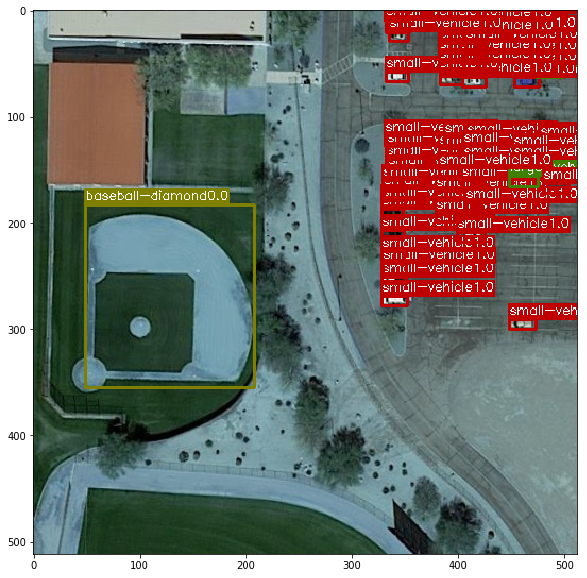

In [4]:
img_name, img, targets = validation_dataset.__getitem__(154)

dummy_example = targets

plt.figure(figsize=(10,10),facecolor='w') 
visualize_bbox_gt(img_name, train = False, img_size = 512)

In [5]:
idx = validation_dataset.image_names.index(img_name)
gt_bbox = validation_dataset.targets[idx]
print(gt_bbox.size())

conobj_mask = (targets[:,:,4] > 0).unsqueeze(-1).expand_as(targets)
conobj_bbox_train = targets[conobj_mask].view(-1,26)
print(conobj_bbox_train.size())

torch.Size([1, 5])
torch.Size([1, 26])


## Load Model

In [6]:
model = Yolov1_vgg16bn(pretrained = True)
model.load_state_dict(torch.load(pretrained_model_path))
model.eval()

if use_gpu:
    model.cuda()

## Predict One

**Processing after prediction**
1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
3. max class probability(tensor): sized [98, 1]

In [7]:
"""
Data processing
    1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
    2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
    3. class probability(tensor): sized [98, 16]
"""

pred_bbox_cxcy, cls_conf, max_cls_code= predict(img, model, DEBUG = DEBUG, dummy_example = dummy_example)

pred_bbox_xy = pred_bbox_revert(pred_bbox_cxcy)

## Filtering

1. filtering by class confidence
2. NMS

**Results**
1. high confidence bounding boxes_xy (tensor), sized [N, 4]: [xmin, ymin, xmax, ymax]
2. high confidence of class (tensor), sized [N, 1]
3. high confidence of class probability (tensor), sized [N, 16]

In [8]:
bbox_xy_final,cls_conf_final,pred_cls_code_final = bbox_filtering(pred_bbox_xy, cls_conf, max_cls_code)

# class names
#max_cls_idx = torch.max(pred_cls_final, 1)[1].tolist() if pred_cls_final.size(0) != 0 else []
cls_labels = [DOTA_CLASSES[idx] for idx in pred_cls_code_final.squeeze(1).tolist()]

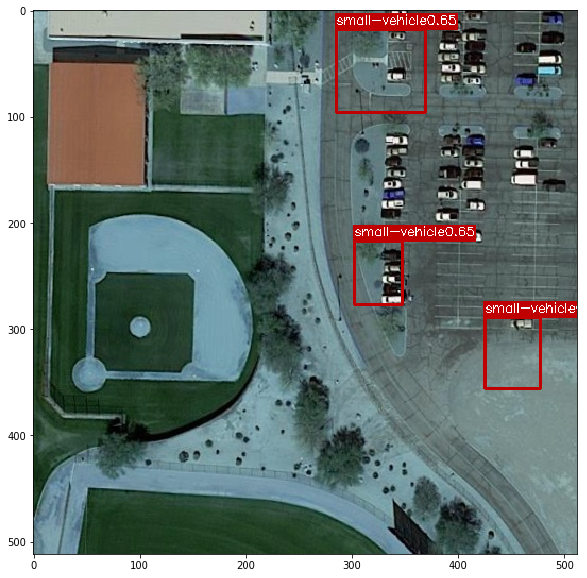

In [9]:
plt.figure(figsize=(10,10),facecolor='w')
visualize_bbox(img_name, bbox_xy_final.tolist(), cls_labels, cls_conf_final.tolist(), img_size = 512, train = False)

In [17]:
import os, shutil

if os.path.isdir('./Test_hbb'):
    shutil.rmtree('./Test_hbb')